In [2]:
import os
import json

def is_target_sequence(filename):
    """Check if filename contains a valid target MRI sequence."""
    targets = ['t1', 't2', 't1gd', 'flair']
    fname = filename.lower()
    return any(seq in fname for seq in targets)

def extract_sequence_label(filename):
    """Return standardized sequence name from filename."""
    fname = filename.lower()
    if 't1gd' in fname:
        return 'T1GD'
    elif 't1' in fname:
        return 'T1'
    elif 't2' in fname:
        return 'T2'
    elif 'flair' in fname:
        return 'FLAIR'
    else:
        return None

def create_json_from_folder(data_root, output_json_path):
    json_list = []
    uid = 1

    for patient_folder in os.listdir(data_root):
        patient_path = os.path.join(data_root, patient_folder)
        if not os.path.isdir(patient_path):
            continue
        
        for file in os.listdir(patient_path):
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                if is_target_sequence(file):
                    label = extract_sequence_label(file)
                    if label:
                        json_item = {
                            "id": uid,
                            "USER": "What mri sequence is this image?",
                            "GT": label,
                            "image_path": [os.path.join(patient_path, file)]
                        }
                        json_list.append(json_item)
                        uid += 1

    with open(output_json_path, 'w') as f:
        json.dump(json_list, f, indent=2)

    print(f"Saved {len(json_list)} items to {output_json_path}")

# 예시 실행
data_root = "/home/hufsaim/VLM/VLM/data/BraTS2020/MICCAI_BraTS2020_ValidationData"  # 최상위 환자 폴더 경로
output_path = "/home/hufsaim/VLM/VLM/m3/demo/0621/q4.json"
create_json_from_folder(data_root, output_path)


Saved 192 items to /home/hufsaim/VLM/VLM/m3/demo/0621/q4.json


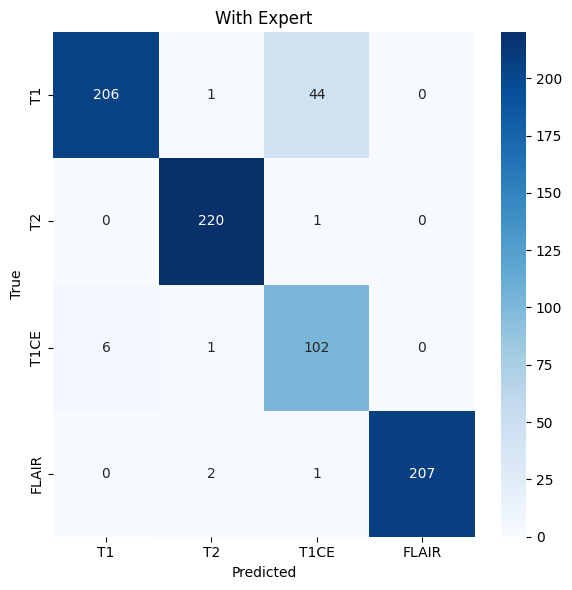

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 파일 경로 설정
paths = [
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/tmp1.json",
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/tmp2.json",
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/brats2020.json"
]
# 데이터 로딩
all_data = []
for path in paths:
    with open(path, "r") as f:
        all_data.extend(json.load(f))

# GT, Pred 수집
gt_labels = []
pred_labels = []
wrong_cases = []

for entry in all_data:
    gt = entry["GT"].strip().upper().replace("T1GD", "T1CE")
    pred = entry["VILA-M3 Final"].strip().upper().replace("CONTRAST-ENHANCED (T1CE)", "T1CE")

    gt_labels.append(gt)
    pred_labels.append(pred)

    if gt != pred:
        wrong_cases.append({
            "id": entry["id"],
            "GT": gt,
            "Pred": pred,
            "image_path": entry["image path"][0] if entry["image path"] else ""
        })

# 라벨 순서 고정
fixed_labels = ["T1", "T2", "T1CE", "FLAIR"]

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(gt_labels, pred_labels, labels=fixed_labels)
cm_df = pd.DataFrame(cm, index=fixed_labels, columns=fixed_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("With Expert")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

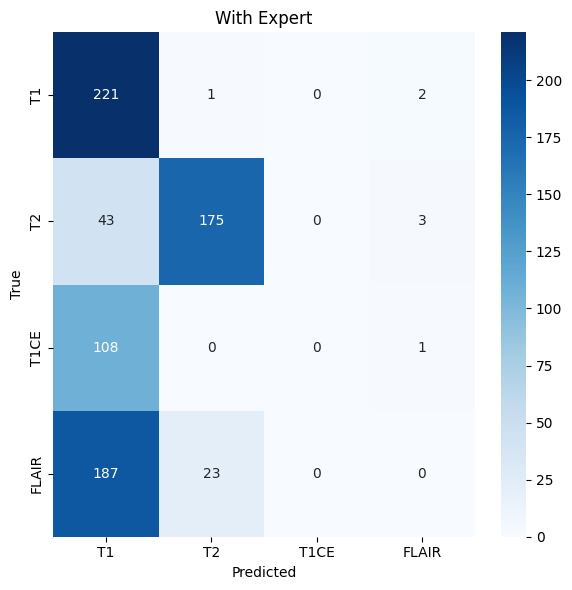

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 파일 경로 설정
paths = [
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/wo_tmp1.json",
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/wo_tmp2.json",
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/wo_brats2020.json"
]
# 데이터 로딩
all_data = []
for path in paths:
    with open(path, "r") as f:
        all_data.extend(json.load(f))

# GT, Pred 수집
gt_labels = []
pred_labels = []
wrong_cases = []

for entry in all_data:
    gt = entry["GT"].strip().upper().replace("T1GD", "T1CE")
    pred = entry["VILA-M3"].strip().upper().replace("CONTRAST-ENHANCED (T1CE)", "T1CE")

    gt_labels.append(gt)
    pred_labels.append(pred)

    if gt != pred:
        wrong_cases.append({
            "id": entry["id"],
            "GT": gt,
            "Pred": pred,
            "image_path": entry["image path"][0] if entry["image path"] else ""
        })

# 라벨 순서 고정
fixed_labels = ["T1", "T2", "T1CE", "FLAIR"]

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(gt_labels, pred_labels, labels=fixed_labels)
cm_df = pd.DataFrame(cm, index=fixed_labels, columns=fixed_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("With Expert")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

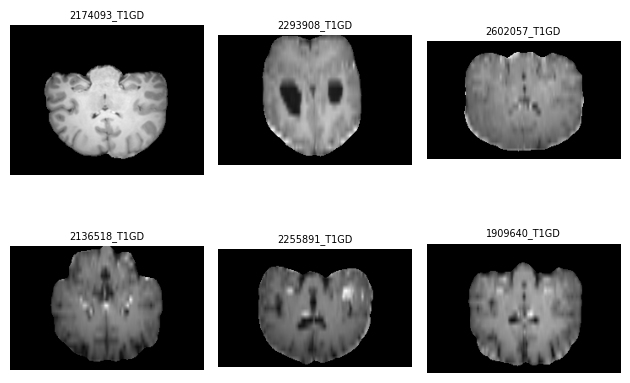

In [31]:
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 원하는 ID 리스트
target_ids = {103, 160, 180, 223, 258, 270}

# 파일 경로들 (필요시 수정)
paths = [
    "/home/hufsaim/VLM/VLM/m3/demo/0621/results/tmp1.json"
]

# 해당 ID의 이미지 경로 수집
selected_paths = []
for path in paths:
    with open(path, 'r') as f:
        data = json.load(f)
        for item in data:
            if item['id'] in target_ids:
                selected_paths.append(item["image path"][0])

# 이미지 시각화 (중앙 슬라이스 한 장씩, 한 행에 출력)
# plt.figure(figsize=(8 , 4))

for i, img_path in enumerate(selected_paths):
    img_name = img_path.split("/")[-1].replace('_stripped.nii.gz', '')
    print(img_name)
    img = nib.load(img_path).get_fdata()
    center_slice = img.shape[2] // 2
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.rot90(img[:, :, center_slice], 3), cmap='gray')
    plt.title(f"{img_name}", fontsize=7)
    plt.axis('off')

plt.tight_layout()
plt.show()


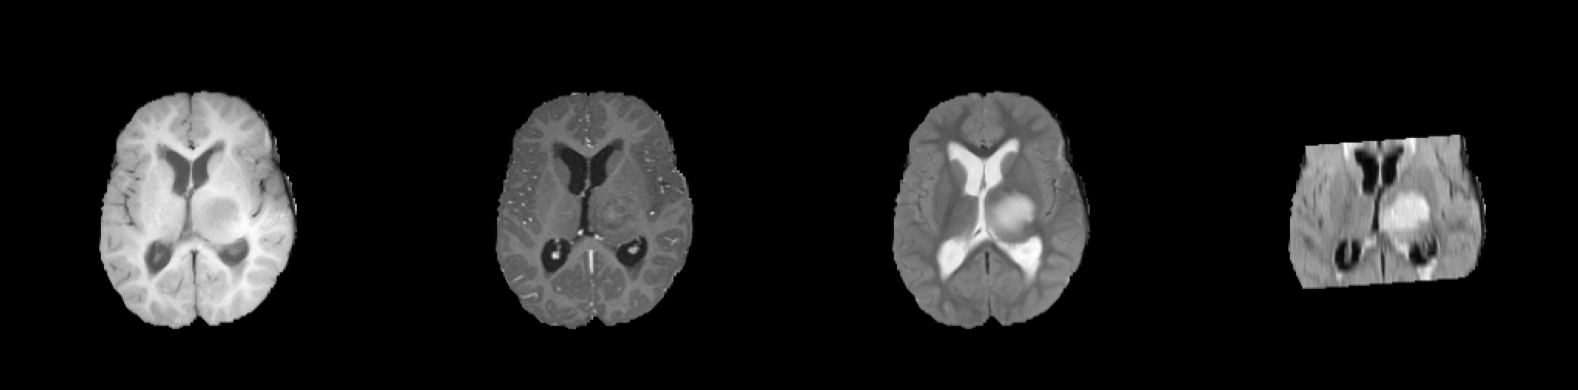

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def plot_mri_images(image_paths):
    """
    Plot 4 MRI images in one row (central axial slice).
    
    Args:
        image_paths (list): List of 4 paths to .nii or .nii.gz files
    """
    if len(image_paths) != 4:
        raise ValueError("Exactly 4 image paths must be provided.")
    plt.style.use('dark_background')
    plt.figure(figsize=(16, 4))

    for i, path in enumerate(image_paths):
        # Load image
        nii = nib.load(path)
        img = nii.get_fdata()

        # Get central slice in axial direction
        z_center = img.shape[2] // 2
        slice_img = img[:, :, z_center]

        # Plot
        plt.subplot(1, 4, i+1)
        plt.imshow(np.rot90(slice_img.T, 2), cmap='gray', origin='lower')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

image_paths = [
    "/home/hufsaim/VLM/VLM/data/for_mps/Brats18_2013_0_1/Brats18_2013_0_1_t1.nii",
      "/home/hufsaim/VLM/VLM/data/for_mps/Brats18_2013_0_1/Brats18_2013_0_1_t1ce.nii",
      "/home/hufsaim/VLM/VLM/data/for_mps/Brats18_2013_0_1/Brats18_2013_0_1_t2.nii",
      "/home/hufsaim/VLM/VLM/data/for_mps/Brats18_2013_0_1/Brats18_2013_0_1_flair.nii"
]

plot_mri_images(image_paths)
